# 021 5x5 Log
O objetivo desse notebook é testar o modelo em ambiente 5x5 para registrar os resultados.

In [1]:
from __future__ import absolute_import, division, print_function

import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import logging
logging.disable(logging.WARNING) 

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

from resources import build_agent, TrainingSession, compute_logs
import pandas as pd
import gc

In [2]:
combination = 0
gamma_option = 0
epsilon_option = 0
buffer_option = 0
lr_option = 0

buffer_options = [100_000, 50_000, 10_000, 1_000, 100]
fc_options = [(100,50), (100,50,50), (200,100), (200,)]

gamma_options = [0.99, 0.9, 0.75, 0.5]
eps_greedy_otions = [0.7, 0.6, 0.5]

lr_options = [1e-4, 1e-3, 1e-2]

In [3]:
# Historical Environments
# 1 - Observation: walls + distance, 3 rewards
# 2 - Observation: walls + r + theta, 4 rewards
# 3 - Observation: walls + r + theta + movement history, 4 rewards
hist_env = 3


# Hiperparameters
num_iterations = 10_000 

initial_collect_steps = 100
collect_steps_per_iteration = 1 
replay_buffer_max_length = buffer_options[buffer_option]  

batch_size = 64  
learning_rate = 1e-3  
log_interval = 100  

num_eval_episodes = 10  
eval_interval = 100  

# Agent fully connected layer params 
fc_layer_params = fc_options[3]
without_wall_training = True
early_stop = "finished2"

# Agent hyperparameters
gamma = gamma_options[gamma_option]
epsilon = eps_greedy_otions[epsilon_option]

# File's name
description = "021"

# Size of the maze
maze_size = 3

# Reward combination
#combination = 2 
run = 1

rewards = []
rewards.append({
    'destroyed': -10.,
    'stuck': - 6.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -11.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -15.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -500.,
    'stuck': 0.,
    'reached': 500.,
    'standard': -10.
})
rewards.append({
    'destroyed': 0.,
    'stuck': 0.,
    'reached': 100.,
    'standard': -10.
})
rewards.append({
    'destroyed': -50.,
    'stuck': 0.,
    'reached': 300.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -11.,
    'reached': 50.,
    'standard': -1.
})



sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

# Importing custom environment
env_name = f'maze-v0-{hist_env}'
env = suite_gym.load(env_name)

# Testing
env.reset()

train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)



## Training Phase 1

In [4]:
# Hiperparâmetros obtidos em 007_grid_search_2_fase_2.py
combination_1 = 0
gamma = gamma_options[1]
epsilon = eps_greedy_otions[0]
replay_buffer_max_length = buffer_options[0]  

# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env, hist_env, epsilon, gamma)
agent.initialize()


# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_1], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=True, 
                                                                                            early_stop="finished")


# LOGGING
df_log_1 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                            'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})

check_1 = agent.train_step_counter.numpy()

Rewards: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Size: 3
Mode: 1
Hist env: 3
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


### Generate the video

In [5]:
from resources import create_policy_eval_video

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(True)
train_py_env.set_size(3)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase1)-{description}", train_env, train_py_env)

In [6]:
from resources import plot_moving_avg

In [7]:
from resources import plot_all_metrics

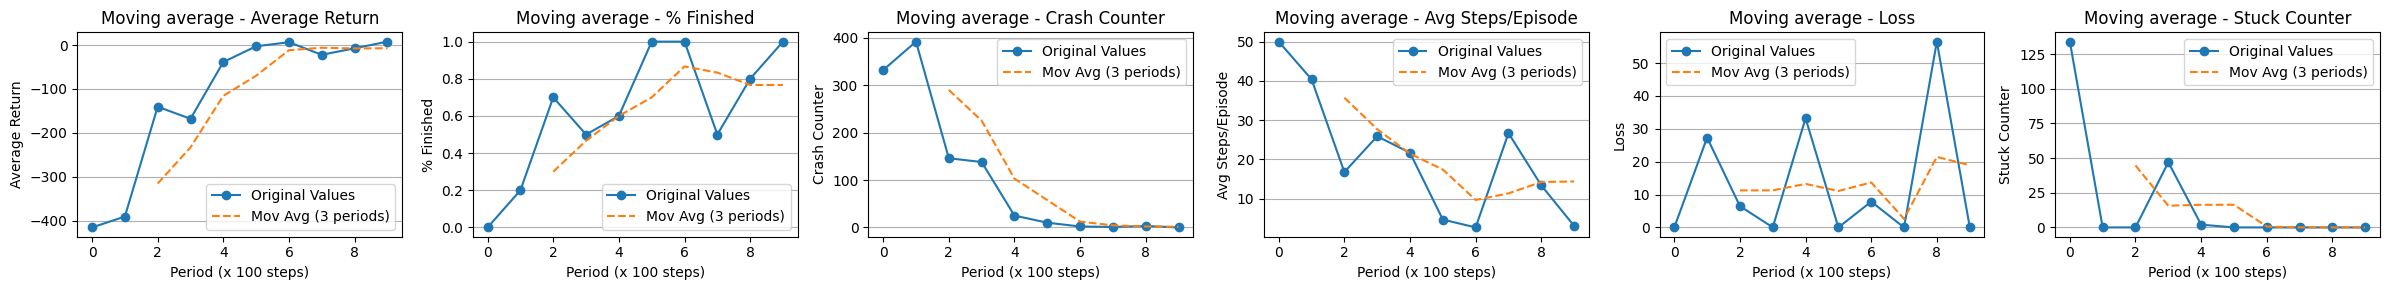

In [8]:
plot_all_metrics(df_log_1, period=-1, hist_env=hist_env)

## Training Phase 2 - Introdução do ambiente com paredes

In [9]:
# Atualiza hiperparametros
combination_2 = 0

gamma = gamma_options[0]
epsilon = eps_greedy_otions[2]
replay_buffer_max_length = buffer_options[1]
    
agent._optimizer.learning_rate = lr_options[1]
agent._epsilon_greedy = epsilon
agent._gamma =  gamma

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_2], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=False, 
                                                                                          early_stop="finished")


# LOGGING
df_log_2 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})

check_2 = agent.train_step_counter.numpy()

Rewards: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Size: 3
Mode: 0
Hist env: 3
step = 1000
step = 2000
step = 3000
step = 4000
step = 5000
step = 6000
step = 7000
step = 8000
step = 9000
step = 10000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


### Generate the Video

In [10]:
from resources import create_policy_eval_video

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(False)
train_py_env.set_size(3)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase2)-{description}", train_env, train_py_env)

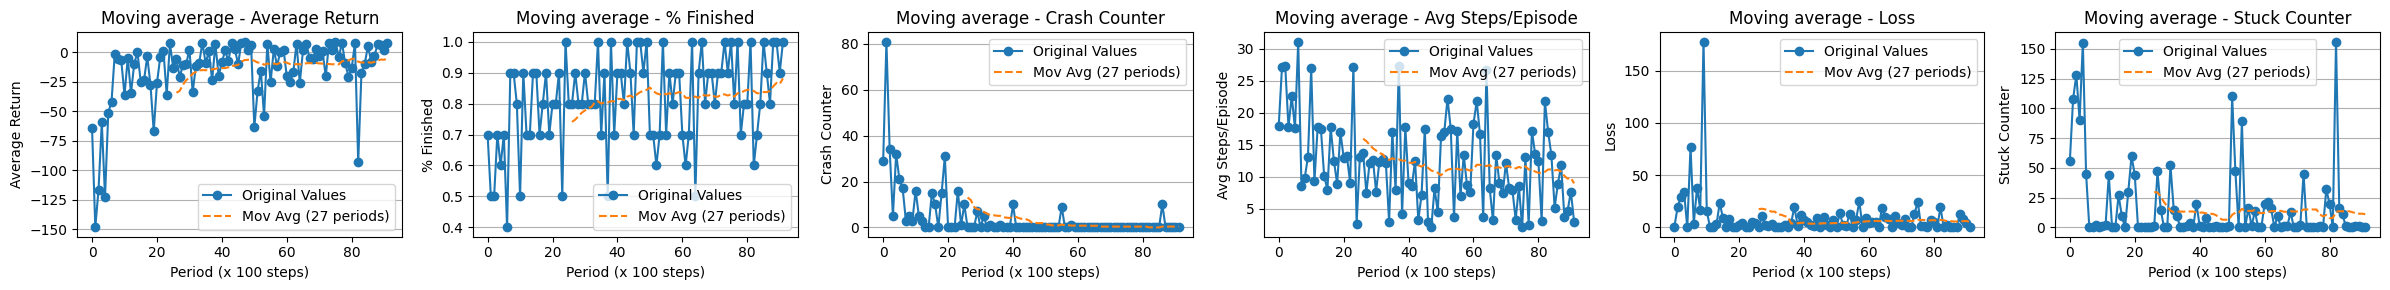

In [11]:
plot_all_metrics(df_log_2, period=-1, hist_env=hist_env)

## Training Phase 3 - Fine Tuning (Refino)

In [12]:
# Atualiza hiperparametros
combination_3 = 1
gamma = gamma_options[3]
epsilon = eps_greedy_otions[2]
replay_buffer_max_length = buffer_options[1]
    
agent._optimizer.learning_rate = lr_options[0]
agent._epsilon_greedy = epsilon
agent._gamma =  gamma

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_3], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=False, early_stop=early_stop)


# LOGGING
df_log_3 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})

check_3 = agent.train_step_counter.numpy()

Rewards: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Size: 3
Mode: 0
Hist env: 3

=============================================================( EARLY STOP )
Big check log:
Avg return: 3.71
Finished: 0.94
Crash Counter: 0
Stuck counter: 3
Early stop at 10100

learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


### Generate the Video

In [13]:
from resources import create_policy_eval_video

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(False)
train_py_env.set_size(3)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase3)-{description}", train_env, train_py_env)

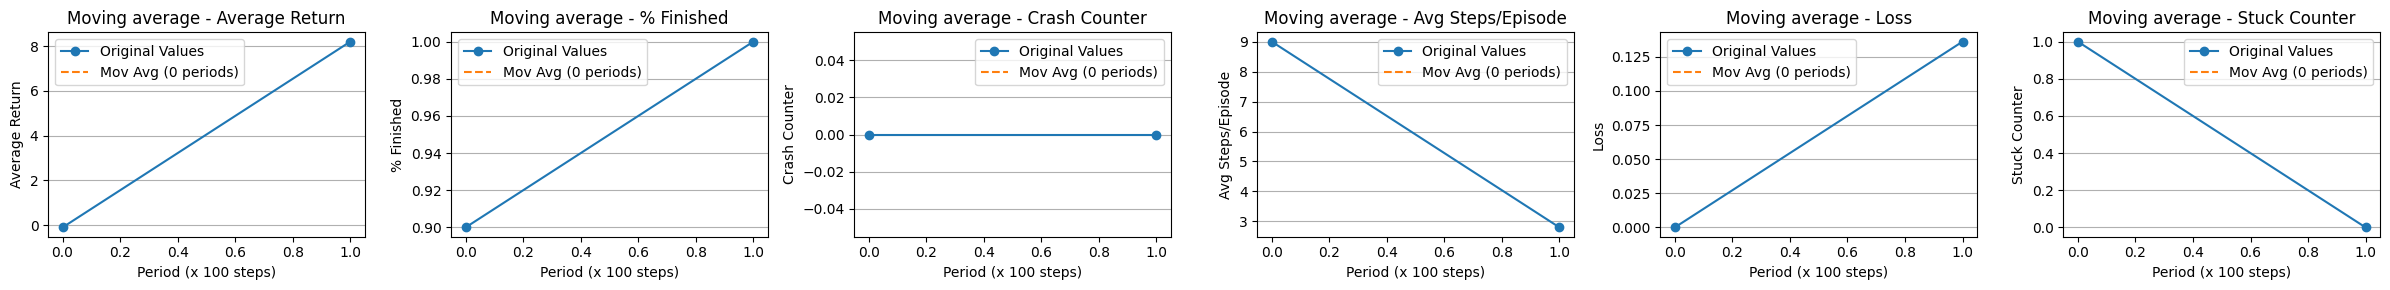

In [14]:
plot_all_metrics(df_log_3, period=-1, hist_env=hist_env)

## Training Phase 4 - Ambiente 5x5 sem paredes

In [15]:
# Atualiza hiperparametros
combination_4 = 0

gamma = gamma_options[0]
epsilon = eps_greedy_otions[2]
replay_buffer_max_length = buffer_options[1]
    
agent._optimizer.learning_rate = lr_options[1]
agent._epsilon_greedy = epsilon
agent._gamma =  gamma

maze_size = 5

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_4], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=True, 
                                                                                          early_stop="finished")


# LOGGING
df_log_4 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})

check_4 = agent.train_step_counter.numpy()

Rewards: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Size: 5
Mode: 1
Hist env: 3
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


### Generate the video

In [16]:
from resources import create_policy_eval_video

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(True)
train_py_env.set_size(4)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase4)-{description}", train_env, train_py_env)

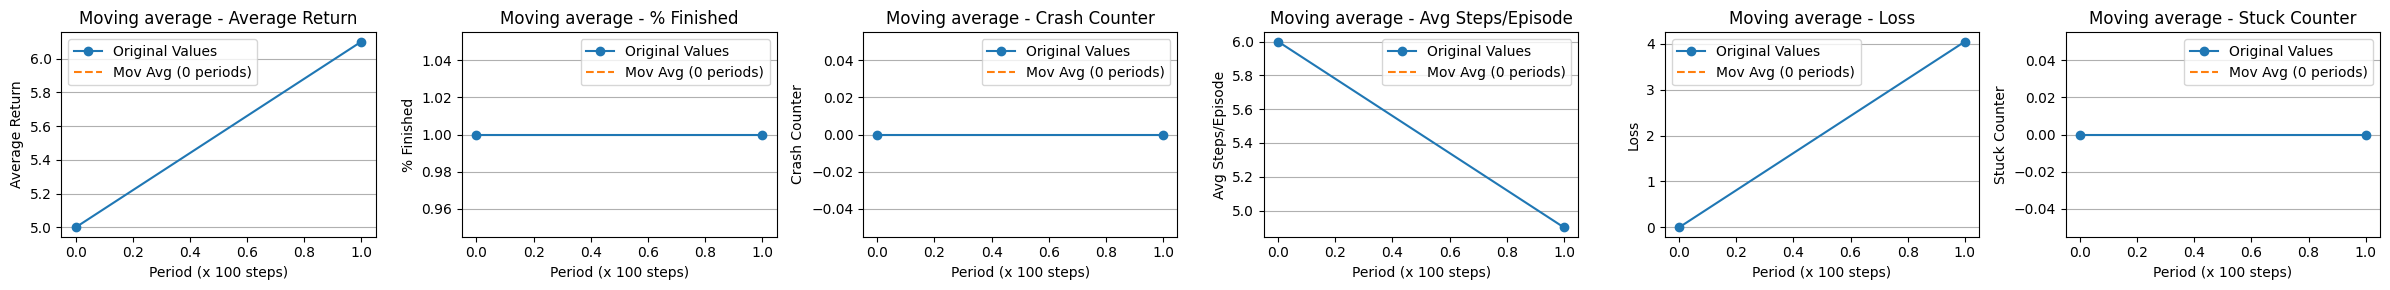

In [17]:
plot_all_metrics(df_log_4, period=-1, hist_env=hist_env)

## Training Phase 5 - Ambiente 5x5 com paredes

In [18]:
# Atualiza hiperparametros
    
combination_5 = 1

gamma = gamma_options[gamma_option]
epsilon = eps_greedy_otions[epsilon_option]
replay_buffer_max_length = buffer_options[buffer_option]
    
agent._optimizer.learning_rate = lr_options[1]
agent._epsilon_greedy = epsilon
agent._gamma =  gamma

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_5], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=False, 
                                                                                          early_stop="finished")


# LOGGING
df_log_5 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})





Rewards: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Size: 5
Mode: 0
Hist env: 3
step = 11000
step = 12000
step = 13000
step = 14000
step = 15000
step = 16000
step = 17000
step = 18000
step = 19000
step = 20000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


### Generating the Video

In [19]:
from resources import create_policy_eval_video

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(False)
train_py_env.set_size(4)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase5)-{description}", train_env, train_py_env)

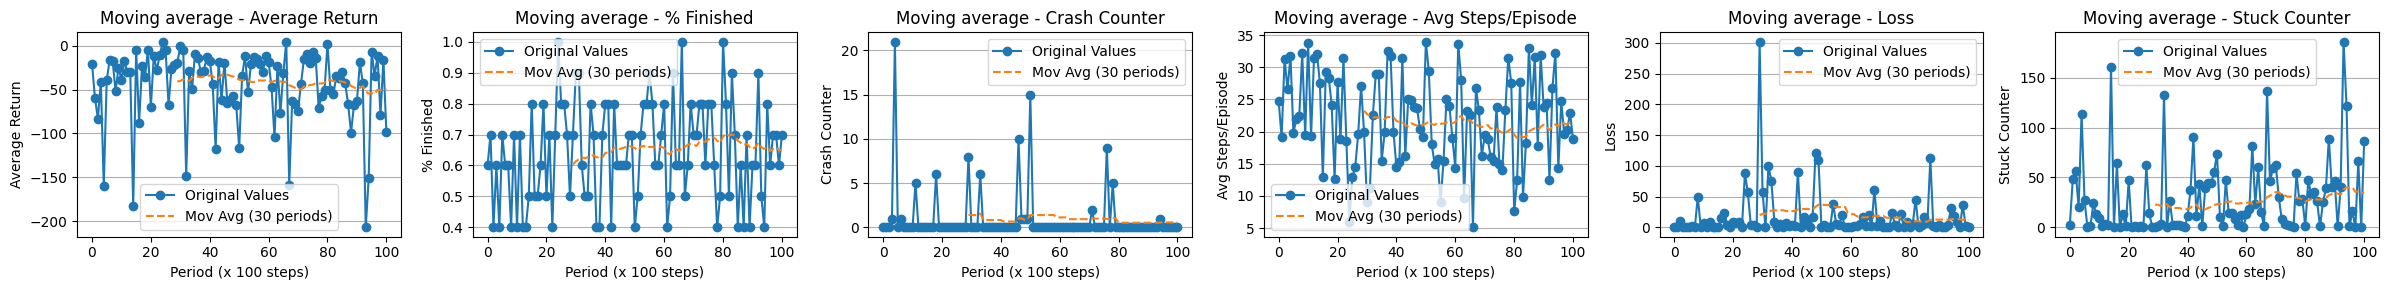

In [20]:
plot_all_metrics(df_log_5, period=-1, hist_env=hist_env)

In [21]:
df_log = pd.concat([df_log_1, df_log_2, df_log_3, df_log_4, df_log_5])
df_log.to_csv(f"logs/06-hist-env/{description}-combination_{combination_5}-epsilon_{epsilon_option}-gamma_{gamma_option}-buffer_{buffer_option}-lr_{lr_option}.csv", index=None, header=True)


In [22]:
# Atualiza hiperparametros
    
combination_5 = 1

gamma = gamma_options[gamma_option]
epsilon = eps_greedy_otions[epsilon_option]
replay_buffer_max_length = buffer_options[buffer_option]
    
agent._optimizer.learning_rate = lr_options[0]
agent._epsilon_greedy = 0.5
agent._gamma =  gamma
num_iterations = 20_000

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_5], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=False, 
                                                                                          early_stop="finished")


# LOGGING
df_log_6 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})



Rewards: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Size: 5
Mode: 0
Hist env: 3
step = 21000
step = 22000
step = 23000
step = 24000
step = 25000
step = 26000
step = 27000
step = 28000
step = 29000
step = 30000
step = 31000
step = 32000
step = 33000
step = 34000
step = 35000
step = 36000
step = 37000
step = 38000
step = 39000
step = 40000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [23]:
# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(False)
train_py_env.set_size(4)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase6)-{description}", train_env, train_py_env, num_episodes=30)

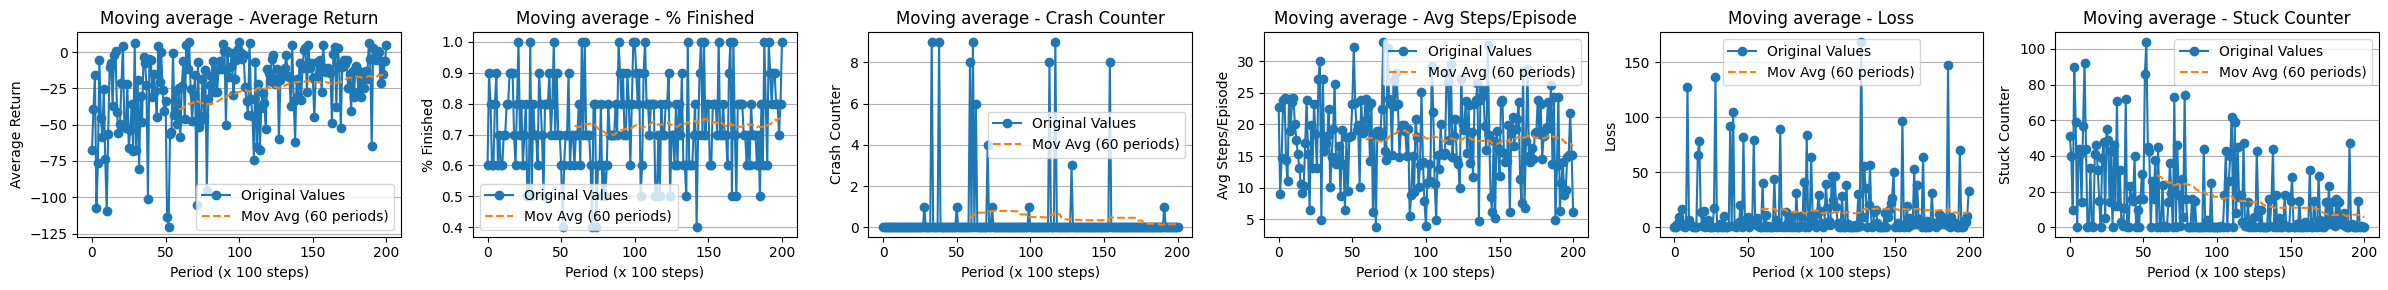

In [24]:
plot_all_metrics(df_log_6, period=-1, hist_env=hist_env)

In [25]:
# Atualiza hiperparametros
    
combination_5 = 1

gamma = gamma_options[gamma_option]
epsilon = eps_greedy_otions[epsilon_option]
replay_buffer_max_length = buffer_options[buffer_option]
    
agent._optimizer.learning_rate = lr_options[0]
agent._epsilon_greedy = 0.5
agent._gamma =  gamma
num_iterations = 20_000

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_5], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=False, 
                                                                                          early_stop="finished")


# LOGGING
df_log_7 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})


Rewards: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Size: 5
Mode: 0
Hist env: 3
step = 41000
step = 42000
step = 43000
step = 44000
step = 45000
step = 46000
step = 47000
step = 48000
step = 49000
step = 50000
step = 51000
step = 52000
step = 53000
step = 54000
step = 55000
step = 56000
step = 57000
step = 58000
step = 59000
step = 60000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [26]:
# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(False)
train_py_env.set_size(5)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase7)-{description}", train_env, train_py_env, num_episodes=30)

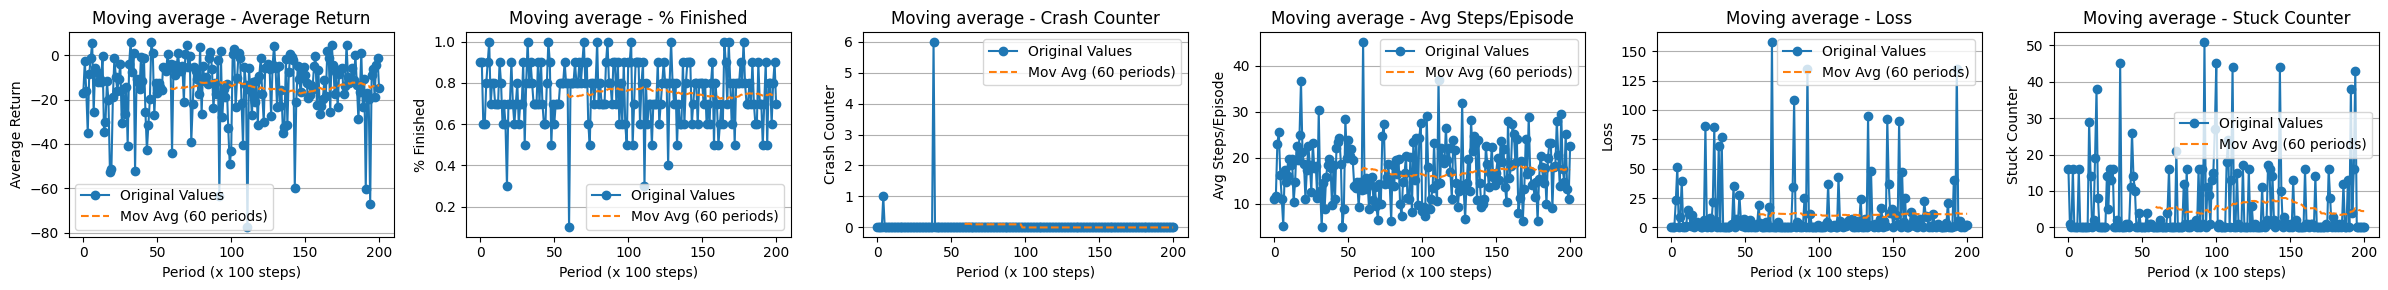

In [27]:
plot_all_metrics(df_log_7, period=-1, hist_env=hist_env)

In [30]:
df_log = pd.concat([df_log_1, df_log_2, df_log_3, df_log_4, df_log_5, df_log_6, df_log_7])
df_log.to_csv(f"logs/06-hist-env/{description}-5x5-combination_{combination_5}-epsilon_{epsilon_option}-gamma_{gamma_option}-buffer_{buffer_option}-lr_{lr_option}.csv", index=None, header=True)


In [31]:
from resources import compute_logs

In [39]:
avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps = compute_logs(train_env, agent.policy, rewards[combination_5], 1000, False, 3)

In [40]:
print(avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps)

-10.529 0.746 0 0 17.423


In [41]:
# ENVIRONMENT
eval_py_env = suite_gym.load(env_name)

eval_py_env.update_rewards(rewards[combination_5]['destroyed'], rewards[combination_5]['stuck'], rewards[combination_5]['reached'], rewards[combination_5]['standard'])

eval_py_env.set_mode(0)

eval_py_env.set_size(5)

eval_py_env.set_hist_env(hist_env)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [42]:
avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps = compute_logs(eval_env, agent.policy, rewards[combination_5], 1000, False, 3)

In [43]:
print(avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps)

-10.178 0.779 0 280 15.947


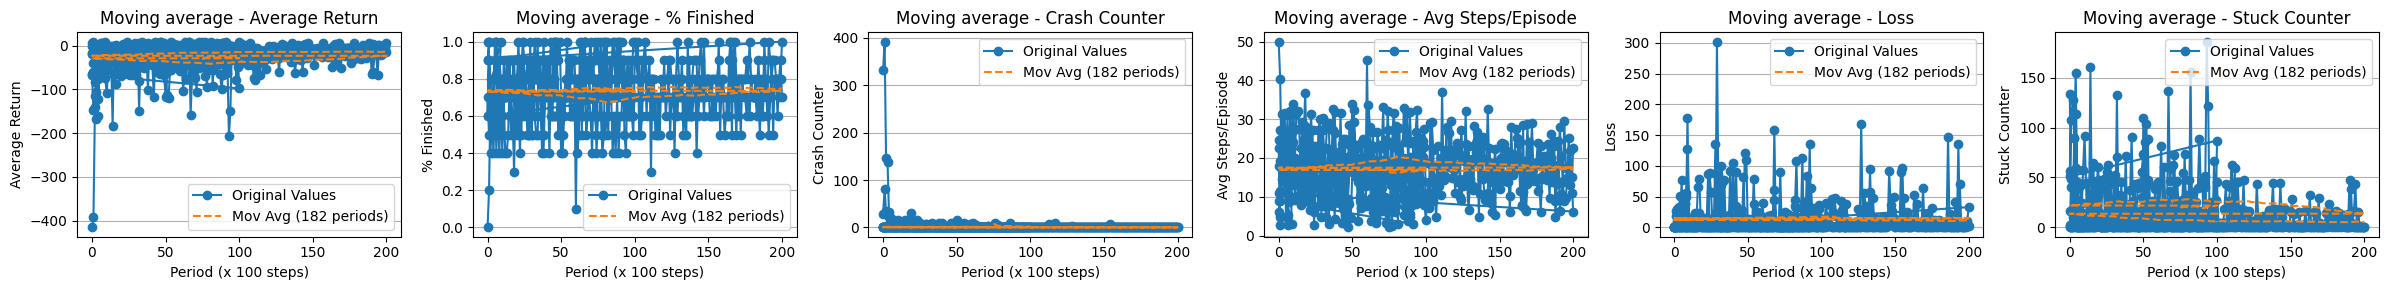

: 

In [ ]:
plot_all_metrics(df_log, period=-1, hist_env=hist_env)